In [2]:
from src.tools import MMseqs
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile
from utils import * 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%load_ext autoreload 
%autoreload 2

In [11]:
def get_filter_datasets(max_length:int=800):

    df = load_ref_out()
    print(f'get_filter_datasets: Loaded {len(df)} proteins from ./ref.out')
    df = remove_partial(df)

    interpro_df = InterProScanFile('../data/putative_protein.interpro.tsv').to_df(max_e_value=1e-5, drop_duplicates=True)
    interpro_df.columns = ['interpro_' + col for col in interpro_df.columns]
    df = df.merge(interpro_df, left_index=True, right_index=True, how='left', validate='one_to_one')

    df['length'] = df.seq.apply(len)
    mask = df.length > max_length
    print(f'get_filter_datasets: Removing {mask.sum()} proteins which exceed the maximum specified length of {max_length}.')
    df = df[~mask].copy()

    df['label'] = df.apply(is_prodigal_error, axis=1).astype(int)
    print(f'get_filter_datasets: {df.label.sum()} out of {len(df)} proteins labeled as Prodigal errors.')

    mask = df.apply(is_ncbi_error, axis=1) & (df.label == 0)
    print(f'get_filter_datasets Removing {mask.sum()} spurious NCBI proteins from the set of "negative" test instances.')
    df = df[~mask]

    mmseqs = MMseqs()
    df = mmseqs.cluster(df, job_name='filter', sequence_identity=0.95, reps_only=True, overwrite=False)
    mmseqs.cleanup()

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    print(f'get_filter_datasets: Training dataset contains {len(train_df)} proteins, testing dataset contains {len(test_df)} proteins.')
    train_df.to_csv('../data/filter_dataset_train.csv')
    test_df.to_csv('../data/filter_dataset_test.csv')

    return train_df, test_df


train_df, test_df = get_filter_datasets()


get_filter_datasets: Loaded 464706 proteins from ./ref.out
remove_partial: Removing 4309 sequences marked as partial by both Prodigal and the reference.
get_filter_datasets: Removing 16946 proteins which exceed the maximum specified length of 800.
get_filter_datasets: 42823 out of 443451 proteins labeled as Prodigal errors.
get_filter_datasets Removing 0 spurious NCBI proteins from the set of "negative" test instances.
MMseqs.load: Removing 3210 non-cluster representatives.
get_filter_datasets: Training dataset contains 352192 proteins, testing dataset contains 88049 proteins.


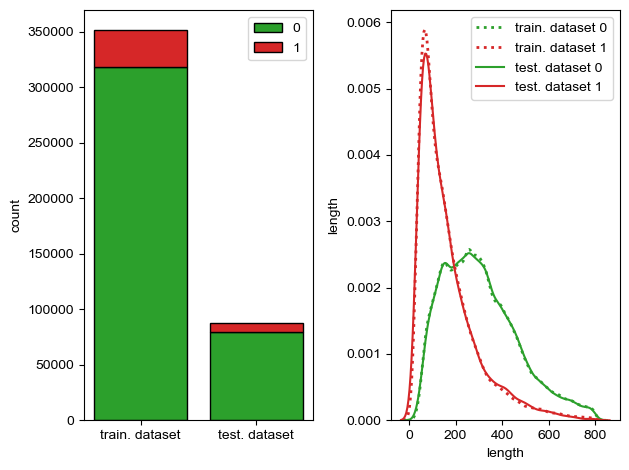

In [12]:
fig, (ax_a, ax_b) = plt.subplots(ncols=2, layout='tight')

positions, bottom = np.arange(2), np.zeros(2)
colors = {0:'tab:green', 1:'tab:red'}
for label in [0, 1]:
    heights = np.array([(df.label == label).sum() for df in [train_df, test_df]])
    ax_a.bar(positions, heights, bottom=bottom, color=colors[label], edgecolor='black', label=str(label))
    bottom += heights
ax_a.set_ylabel('count')
ax_a.set_xticks([0, 1], labels=['train. dataset', 'test. dataset'])
ax_a.legend()

for label, df in train_df.groupby('label'):
    sns.kdeplot(df.length, color=colors[label], label=f'train. dataset {label}', ax=ax_b, ls=':', lw=2)
for label, df in test_df.groupby('label'):
    sns.kdeplot(df.length, color=colors[label], label=f'test. dataset {label}', ax=ax_b)
ax_b.set_ylabel('density')
ax_b.set_ylabel('length')
ax_b.legend()

plt.show()

In [ ]:
def get_mixed_dtype_cols(df:pd.DataFrame):
    mixed_dtype_cols = dict()
    for col in df.columns:
        dtypes = df[col].apply(type).unique()
        if len(dtypes) > 1:
            mixed_dtype_cols[col] = dtypes
            # dtypes = ' '.join([str(dtype) for dtype in dtypes])
            # print(f'get_mixed_dtype_cols: Column {col} has datatypes {dtypes}.')
    return mixed_dtype_cols


def fix_mixed_dtype_cols(df:pd.DataFrame):
    df = df.copy()
    mixed_dtype_cols = get_mixed_dtype_cols(df)

    with pd.option_context('future.no_silent_downcasting', True): # Opt-in to future pandas behavior, which will raise a warning if it tries to downcast.
        for col, dtypes in mixed_dtype_cols.items():
            if (str in dtypes) and (float in dtypes):
                df[col] = df[col].fillna('none')
                print(f'fix_mixed_dtype_cols: Replaced NaNs in column {col} with "none."')
            elif (bool in dtypes) and (float in dtypes):
                df[col] = df[col].fillna(False)
                print(f'fix_mixed_dtype_cols: Replaced NaNs in column {col} with False.')
            else:
                dtypes = ' '.join([str(dtype) for dtype in dtypes])
                raise Exception(f'fix_mixed_dtype_cols: No rule for column {col}, with datatypes {dtypes}.')
    return df 

fix_mixed_dtype_cols(train_df)
fix_mixed_dtype_cols(test_df)


fix_mixed_dtype_cols: Replaced NaNs in column ref_locus_tag with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_feature with False.
fix_mixed_dtype_cols: Replaced NaNs in column in_frame_hit with "none."
fix_mixed_dtype_cols: Replaced NaNs in column start_aligned_hit with "none."
fix_mixed_dtype_cols: Replaced NaNs in column stop_aligned_hit with "none."
fix_mixed_dtype_cols: Replaced NaNs in column ref_contig_id with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_partial with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_product with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_note with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_protein_id with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_seq with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_pseudo with "none."
fix_mixed_dtype_cols: Replaced NaNs in column ref_inference with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_experiment with False.
